<a href="https://colab.research.google.com/github/ashesh-12/Brain_Tumor_Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Brain Tumor Detection Using Deep Learning (MRI Images)

This project uses deep learning and transfer learning (VGG16) to detect brain tumors from MRI images. The goal is to classify MRI scans into four categories: **glioma**, **meningioma**, **pituitary**, and **no tumor**. We utilize a pre-trained CNN model to build a robust classifier and evaluate its performance on real MRI scan data.

---


## ⚙️ Setting Up the Environment

Importing all the necessary libraries for image processing, model building, and data handling.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving requirements.txt to requirements.txt


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install tensorflow==2.18.0

  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 121.7 MB/s eta 0:

In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.3 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 0.28.0 Requires-Python >=3.7, <3.11
ERROR: Could not find a version that satisfies the requirement tensorflow_intel==2.18.0 (from versions: 0.0.1)
ERROR: No matching distribution found for tensorflow_intel==2.18.0


In [2]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

## 📂 Loading and Preparing the Dataset

We load the MRI image dataset from Google Drive. The dataset is divided into **Training** and **Testing** directories, each containing subfolders for the four categories:
- `glioma`
- `meningioma`
- `pituitary`
- `no_tumor`

All image paths and their corresponding labels are collected, and the data is shuffled to ensure randomness during training and evaluation.


In [3]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/Brain Tumor/brain_tumor_mri_dataset/Training/'
test_dir = '/content/drive/MyDrive/Brain Tumor/brain_tumor_mri_dataset/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

## 🖼️ Visualizing Sample Training Images

This code randomly selects 10 images from the training dataset, resizes them to a consistent size (224x224), and displays them in a 2-row, 5-column grid using matplotlib. Each image is shown without axis ticks, and its corresponding class label is displayed as the title below the image.


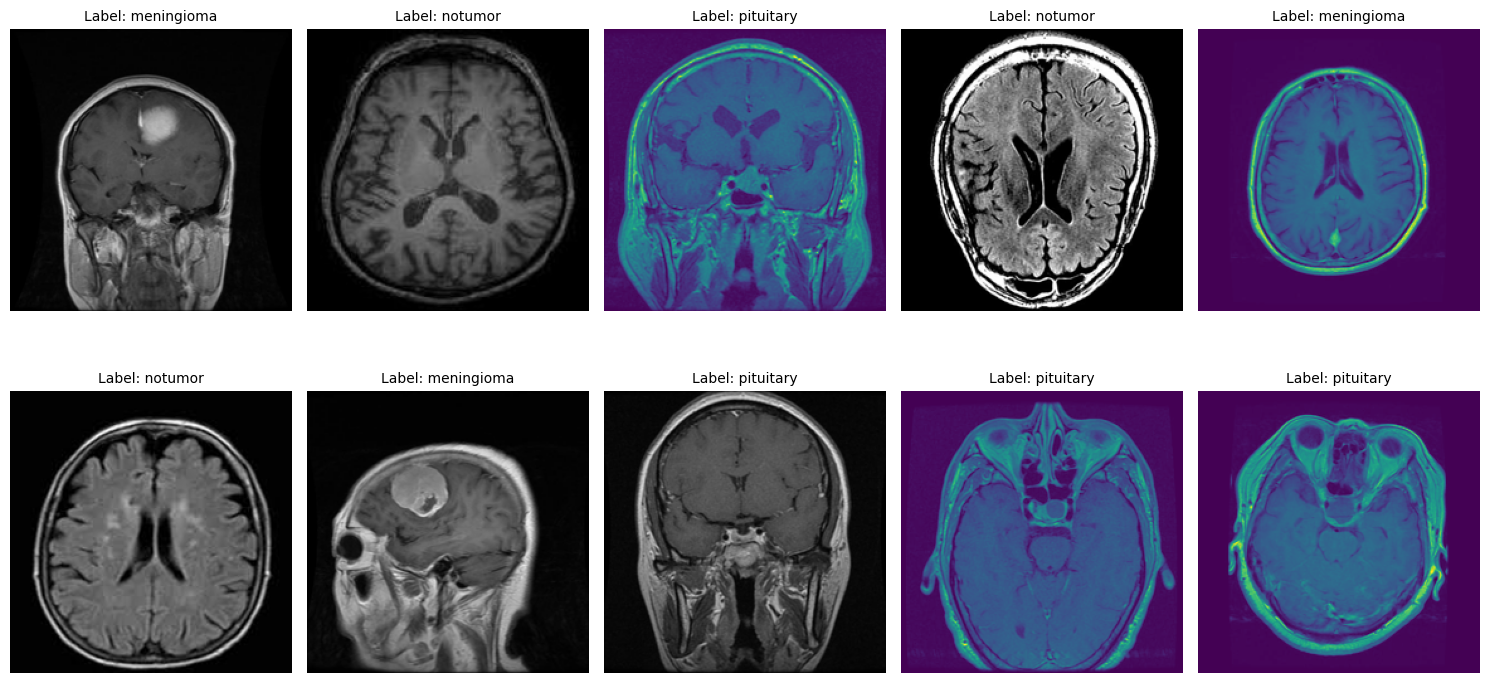

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

## 🔄 Data Preparation: Image Augmentation, Loading, Encoding, and Batch Generation

This section defines functions to preprocess the MRI images before training. It includes image augmentation to improve model robustness, loading images with resizing, encoding string labels to numeric format, and creating a data generator to yield batches of augmented images and labels during training.


In [5]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

## 🧠 Model Architecture: Transfer Learning Using VGG16

This project uses **VGG16**, a popular pre-trained Convolutional Neural Network (CNN), for transfer learning to detect brain tumors from MRI images.

- The **VGG16 model** is loaded with the following settings:  
  - `input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)`, matching the input image size (e.g., 128x128 pixels with 3 color channels).  
  - `include_top = False`, which excludes the original classification layers at the top of VGG16, so we can add our own classifier layers tailored to this problem.  
  - `weights = 'imagenet'`, meaning the model is pre-trained on the large ImageNet dataset with 1.4 million images and 1000 classes.

- To preserve the learned features and avoid overfitting, **all layers in the base VGG16 model are frozen** (set as non-trainable), so their weights will not update during training.

- However, the **last three layers of VGG16 are unfrozen** (set to trainable) to allow fine-tuning of the higher-level feature representations for better adaptation to the brain tumor dataset.

- A **new Sequential model** is created:  
  - The base VGG16 model is added first.  
  - A **Flatten layer** reshapes the output tensor from 3D (height, width, channels) to 1D, preparing it for fully connected layers.  
  - A **Dropout layer** with 30% rate is added to reduce overfitting by randomly disabling some neurons during training.  
  - A **Dense (fully connected) layer** with 128 neurons and ReLU activation introduces non-linearity and learns complex patterns.  
  - Another **Dropout layer** with 20% rate is added for further regularization.  
  - Finally, an **output Dense layer** with neurons equal to the number of unique classes is added, using the **softmax activation** function to produce a probability distribution over the classes.

This architecture leverages the powerful feature extraction capabilities of VGG16 while customizing the classifier to accurately detect brain tumor types in MRI images.


## 🧱 Model Architecture & Training Setup: Building and Training the VGG16-based Brain Tumor Classifier

This code block defines the deep learning model using transfer learning with VGG16 and sets up the training pipeline.


In [6]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [8]:
# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


In [10]:
# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

In [11]:
# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1052s 4s/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7505
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 863s 3s/step - loss: 0.2536 - sparse_categorical_accuracy: 0.9078
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 859s 3s/step - loss: 0.1835 - sparse_categorical_accuracy: 0.9283
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 857s 3s/step - loss: 0.1241 - sparse_categorical_accuracy: 0.9562
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 857s 3s/step - loss: 0.0934 - sparse_categorical_accuracy: 0.9649


In [12]:
# Save the entire model
model.save('model.h5')

# Plotting Model Training History

This section visualizes the training performance of the deep learning model over the specified number of epochs.


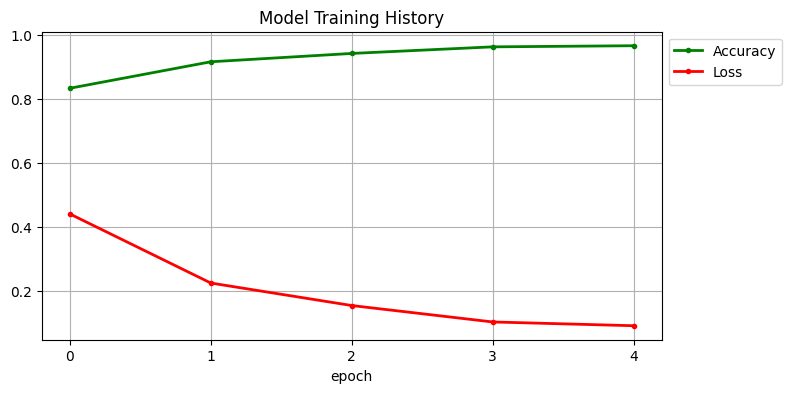

In [13]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Evaluation: Predictions and Classification Report

This code block focuses on evaluating the trained brain tumor detection model on the test dataset.

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       300
           1       0.81      0.97      0.88       306
           2       0.99      1.00      0.99       405
           3       0.99      0.96      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



# Confusion Matrix Visualization

This section calculates and visualizes the confusion matrix to evaluate the performance of the brain tumor detection model on the test dataset.

Confusion Matrix:
[[240  59   0   1]
 [  3 296   4   3]
 [  0   2 403   0]
 [  2   9   0 289]]


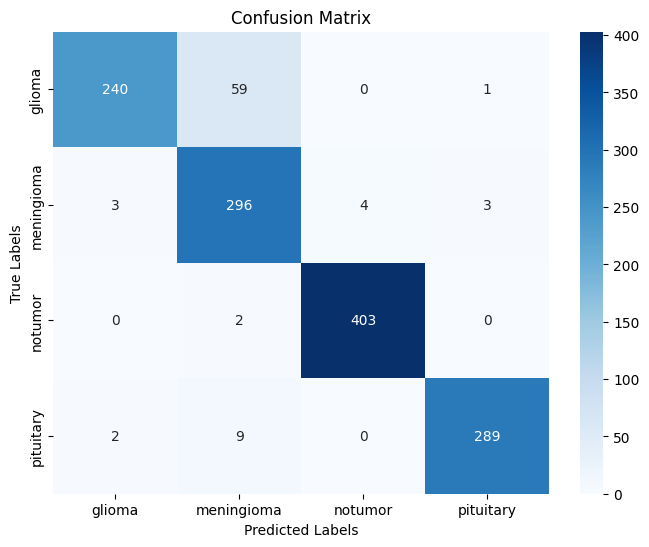

In [16]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC Curve and AUC Analysis

This section evaluates the model’s classification performance using ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve) metrics for multi-class classification.


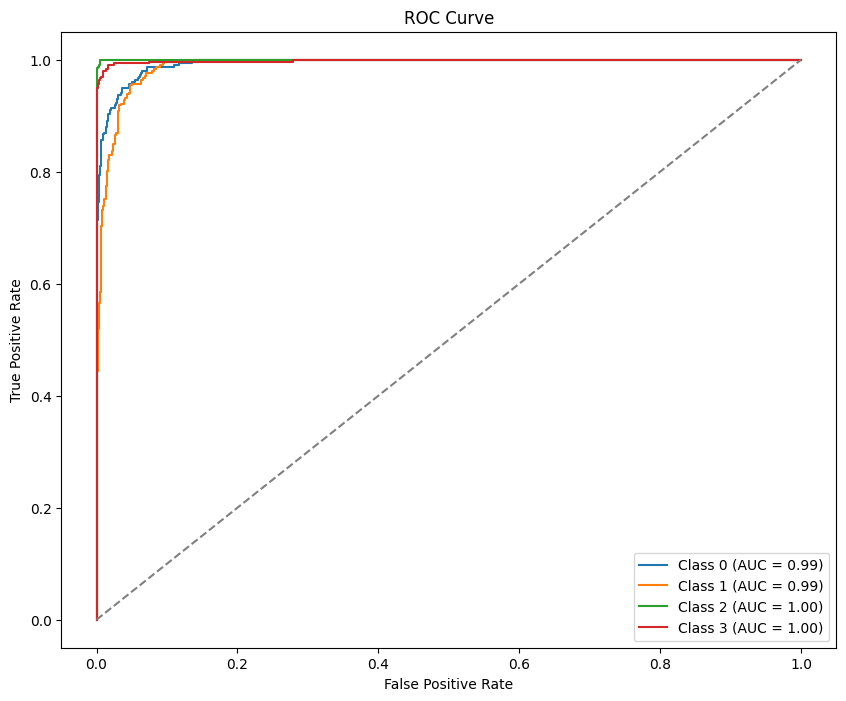

In [17]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [18]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


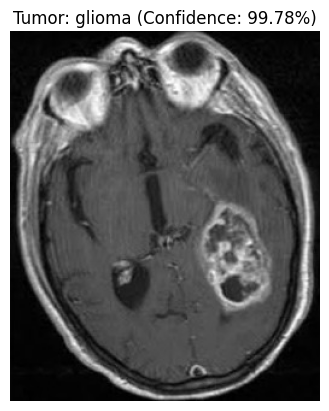

In [32]:
# Example usage
image_path = '/content/drive/MyDrive/Brain Tumor/brain_tumor_mri_dataset/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


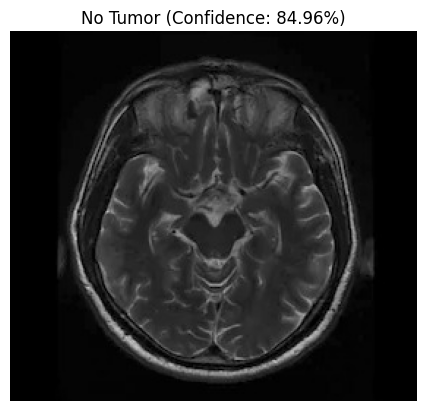

In [40]:
image_path = '/content/drive/MyDrive/Brain Tumor/brain_tumor_mri_dataset/Testing/notumor/Te-noTr_0006.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


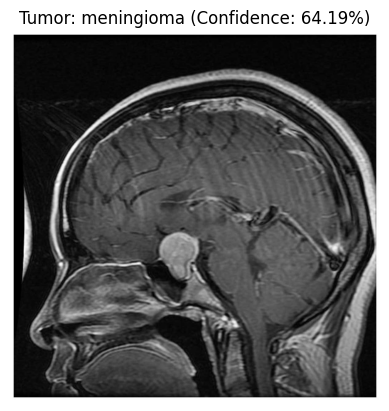

In [35]:
image_path = '/content/drive/MyDrive/Brain Tumor/brain_tumor_mri_dataset/Testing/pituitary/test.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


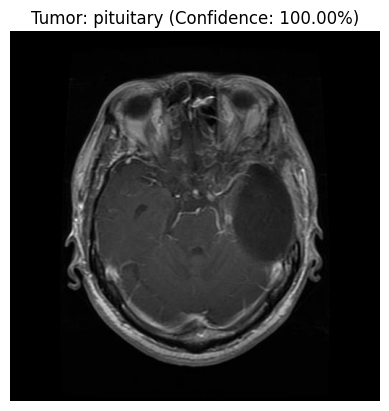

In [30]:
# Example usage
image_path = '/content/drive/MyDrive/Brain Tumor/brain_tumor_mri_dataset/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)